In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Concatenate, Input, Lambda,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel

In [3]:
# Dataset directory and class names
dataset_dir = "/content/drive/MyDrive/IND_and_NEP"  # Replace with your dataset path
class_names = ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']

# Class name to label mapping
class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

# List to store images and labels
images = []
labels = []

# Maximum number of images to load per class
max_images_per_class = 500  # Adjust this as needed

# Load images and labels
for class_name in class_names:
    class_folder = os.path.join(dataset_dir, class_name)
    counter = 0
    for filename in os.listdir(class_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(class_folder, filename)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_map[class_name])
            counter += 1
            if counter >= max_images_per_class:
                break

# Convert images and labels to numpy arrays
images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
labels = np.array(labels, dtype=np.int32)
labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (2400, 224, 224, 3), Validation shape: (300, 224, 224, 3), Test shape: (300, 224, 224, 3)


In [18]:
resnet_base = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freeze ResNet layers
#for layer in resnet_base.layers:
#   layer.trainable = False
resnet_base.trainable = False
# Get ResNet output
resnet_output = resnet_base.output
resnet_output = GlobalMaxPooling2D()(resnet_output)

In [19]:
output = Dense(len(class_names), activation='softmax')(resnet_output)


In [20]:
model = Model(inputs=resnet_base.input, outputs=output)

In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=2,
    epochs=8
)
train_accuracy = history.history['accuracy'][-1]  # Accuracy of the last epoch
val_accuracy = history.history['val_accuracy'][-1]
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
final_training_loss = history.history["loss"][-1]
final_validation_loss = history.history["val_loss"][-1]
print(f"Training Loss: {final_training_loss:.4f}")
print(f"Validation Loss: {final_validation_loss:.4f}")


Epoch 1/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8697 - loss: 0.3625 - val_accuracy: 0.8700 - val_loss: 0.3396
Epoch 2/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8984 - loss: 0.2955 - val_accuracy: 0.8500 - val_loss: 0.4130
Epoch 3/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8802 - loss: 0.3428 - val_accuracy: 0.8767 - val_loss: 0.3163
Epoch 4/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8857 - loss: 0.3057 - val_accuracy: 0.8033 - val_loss: 0.5196
Epoch 5/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8719 - loss: 0.3574 - val_accuracy: 0.8033 - val_loss: 0.6217
Epoch 6/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8887 - loss: 0.3218 - val_accuracy: 0.8067 - val_loss: 0.7123
Epoch 7/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8831 - loss: 0.3145 - val_accuracy: 0.9300 - val_loss: 0.2653
Epoch 8/8
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8774 - loss: 0

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss :.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.9147 - loss: 0.2242
Test Accuracy: 93.00%
Test Loss: 0.20


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 441ms/step


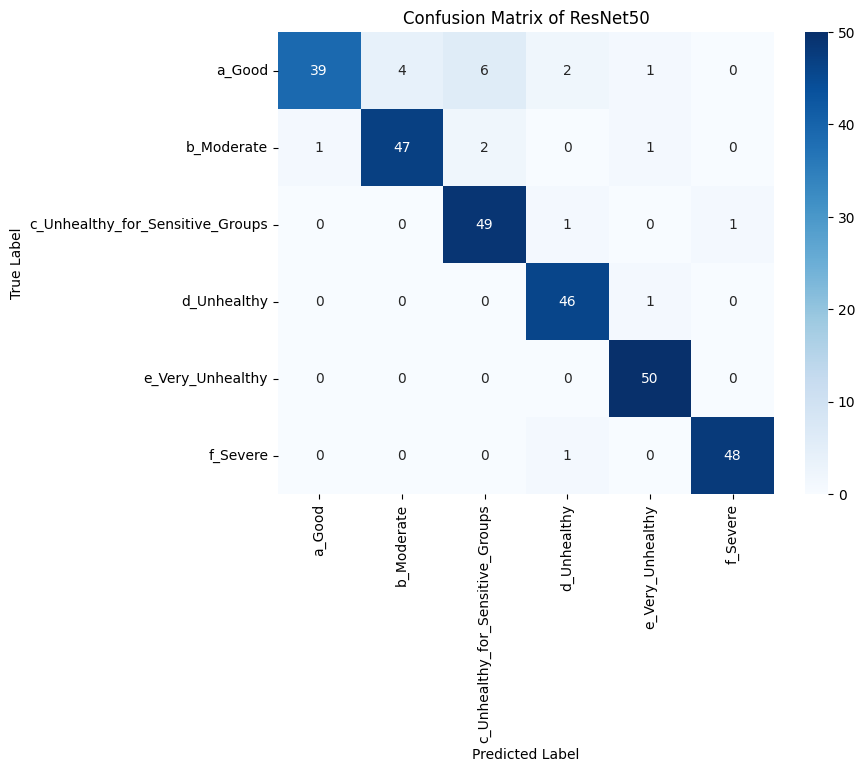

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)  # Use test data for both ResNet and ViT inputs
y_pred_class = np.argmax(y_pred, axis=1)  # Get the class predictions

# Get the true labels (use the same class encoding as before)
y_true_class = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix of ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [31]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

y_train_pred = np.argmax(model.predict(X_train), axis=1)
# Convert true labels to categorical
y_train_true = np.argmax(y_train, axis=1)
# Print classification reports
print("Training Classification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=class_names))

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step
Training Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.97      0.81      0.88       382
                      b_Moderate       0.89      0.97      0.93       401
c_Unhealthy_for_Sensitive_Groups       0.91      0.93      0.92       404
                     d_Unhealthy       0.93      1.00      0.97       399
                e_Very_Unhealthy       0.99      0.99      0.99       409
                        f_Severe       0.98      0.97      0.98       405

                        accuracy                           0.94      2400
                       macro avg       0.95      0.94      0.94      2400
                    weighted avg       0.95      0.94      0.94      2400



In [32]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)
print("Validation Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Validation Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.94      0.77      0.85        66
                      b_Moderate       0.84      0.96      0.89        48
c_Unhealthy_for_Sensitive_Groups       0.93      0.89      0.91        45
                     d_Unhealthy       0.93      0.98      0.95        54
                e_Very_Unhealthy       0.89      1.00      0.94        41
                        f_Severe       0.96      0.93      0.95        46

                        accuracy                           0.91       300
                       macro avg       0.91      0.92      0.92       300
                    weighted avg       0.92      0.91      0.91       300



In [33]:
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)
print("Test Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Test Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.97      0.75      0.85        52
                      b_Moderate       0.92      0.92      0.92        51
c_Unhealthy_for_Sensitive_Groups       0.86      0.96      0.91        51
                     d_Unhealthy       0.92      0.98      0.95        47
                e_Very_Unhealthy       0.94      1.00      0.97        50
                        f_Severe       0.98      0.98      0.98        49

                        accuracy                           0.93       300
                       macro avg       0.93      0.93      0.93       300
                    weighted avg       0.93      0.93      0.93       300



In [34]:
train_metrics = precision_recall_fscore_support(y_train_true, y_train_pred, average='weighted')
val_metrics = precision_recall_fscore_support(y_val_true, y_val_pred, average='weighted')
test_metrics = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')

print(f"Training Precision: {train_metrics[0]:.2f}, Recall: {train_metrics[1]:.2f}, F1-Score: {train_metrics[2]:.2f}")
print(f"Validation Precision: {val_metrics[0]:.2f}, Recall: {val_metrics[1]:.2f}, F1-Score: {val_metrics[2]:.2f}")
print(f"Test Precision: {test_metrics[0]:.2f}, Recall: {test_metrics[1]:.2f}, F1-Score: {test_metrics[2]:.2f}")

Training Precision: 0.95, Recall: 0.94, F1-Score: 0.94
Validation Precision: 0.92, Recall: 0.91, F1-Score: 0.91
Test Precision: 0.93, Recall: 0.93, F1-Score: 0.93
